## Day 5: Optimal Mind Control

Welcome to Day 6! Now that we can simulate a model of a network of conductance-based neurons, we discuss the limitations of our algorithm and try to find solutions to the problems.

### Memory Management

This TensorFlow implementation allows us to make our simulation code not only easier to read but also makes it highly parallizable and scalable across a variety of computational devices. But there are some major limitations to our system. The biggest of these issues is that despite making the simulation faster, this implementation makes it very memory intensive.

The iterators in TensorFlow do not follow the normal process of Memory Allocation and Garbage Collection. Since, TensorFlow is designed to work on sophisticated hardware like GPUs, TPUs and distributed platforms, the memory allocation is done during TensorFlow session adaptively, but the memory is NOT cleared until the python kernel has stopped execution. 

The memory used increases linearly with time as the state matrix is computed recursively by the Scan function. The maximum memory used by the computational graph is 2 times the total state matrix size at the point when the computation finishes and copies the final data into the memory. Larger and more complicated the network and longer the simulation, larger the matrix and then, each run is limited by the total available memory. As we increase the number of neurons (n) and scale the degree distributions, the size of the memory used grows ~$O(n^2)$ as the number of differential equations grows as a square of the number of neurons. Similarly, as we increase the length of the simulation(L), the memory used grows $O(L)$. Which is why for a system with a limited memory of K bytes, The length of a given simulation (L timesteps) of a given network (N differential equations) with 64-bit floating-point precision will follow: 

$$2\times64\times L\times N=K$$ 

That is, for any given network, our maximum simulation length is limited. One way to improve our maximum length is to divide the simulation into smaller batches. There will be a small queuing time between batches, which will slow down our code by a small amount but we will be able to simulate longer times. Thus, if we split the simulation into K sequential batches, the maximum memory for the simulation becomes $(1+\frac{1}{K})$ times the total matrix size. Thus the memory relation becomes:  

$$\Big(1+\frac{1}{K}\Big)\times64\times L\times N=K$$ 

This way, we can maximize the length of out simulation that we can run in a single python kernel.

Let us implement this batch system for our 3 neuron feed-forward model.

### Implementing the Model

To improve out readability and make our code more modular we seperate the integrator into a independent import module. Take the integrator code that we developed in the last day and place it in a file called "tf_integrator.py". Make sure the file is present in the same directory as the implementation of the model. 

Note: If you are using Jupyter Notebook, remember to remove the %matplotlib inline command as it is specific to jupyter.

#### Importing tf_integrator and other requirements

Once the Integrator is saved in tf_integrator.py in the same directory as the Notebook, we can start importing the essentials including the integrator.

In [ ]:
import tensorflow as tf
import numpy as np
import tf_integrator as tf_int
import matplotlib.pyplot as plt
import seaborn as sns

### Recall the Model

For implementing a Batch system, we do not need to change how we construct our model only how we execute it.

#### Step 1: Initialize Parameters and Dynamical Equations; Define Input

In [ ]:
n_n = 3 # number of simultaneous neurons to simulate

sim_res = 0.01                     # Time Resolution of the Simulation
sim_time = 700                     # Length of the Simulation
t = np.arange(0,sim_time,sim_res) 

# Acetylcholine

ach_mat = np.zeros((n_n,n_n))        # Ach Synapse Connectivity Matrix
ach_mat[1,0]=1

## PARAMETERS FOR ACETYLCHLOLINE SYNAPSES ##

n_ach = int(np.sum(ach_mat))     # Number of Acetylcholine (Ach) Synapses 
alp_ach = [10.0]*n_ach           # Alpha for Ach Synapse
bet_ach = [0.2]*n_ach            # Beta for Ach Synapse
t_max = 0.3                          # Maximum Time for Synapse
t_delay = 0                          # Axonal Transmission Delay
A = [0.5]*n_n                        # Synaptic Response Strength
g_ach = [0.35]*n_n                   # Ach Conductance
E_ach = [0.0]*n_n                    # Ach Potential

# GABAa

gaba_mat = np.zeros((n_n,n_n))       # GABAa Synapse Connectivity Matrix
gaba_mat[2,1] = 1

## PARAMETERS FOR GABAa SYNAPSES ##

n_gaba = int(np.sum(gaba_mat)) # Number of GABAa Synapses
alp_gaba = [10.0]*n_gaba       # Alpha for GABAa Synapse
bet_gaba = [0.16]*n_gaba       # Beta for GABAa Synapse
V0 = [-20.0]*n_n                     # Decay Potential
sigma = [1.5]*n_n                    # Decay Time Constant
g_gaba = [0.8]*n_n                  # fGABA Conductance
E_gaba = [-70.0]*n_n                # fGABA Potential

## Storing Firing Thresholds ##

F_b = [0.0]*n_n                      # Fire threshold

def I_inj_t(t):
    return tf.constant(current_input.T,dtype=tf.float64)[tf.to_int32(t/sim_res)] # Turn indices to integer and extract from matrix

## Acetylcholine Synaptic Current ##

def I_ach(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),ach_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((o_*(V-E_ach))*g_ach),1)

## GABAa Synaptic Current ##

def I_gaba(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),gaba_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((o_*(V-E_gaba))*g_gaba),1)

## Other Currents ##

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

def dXdt(X, t):
    V = X[:1*n_n]       # First n_n values are Membrane Voltage
    m = X[1*n_n:2*n_n]  # Next n_n values are Sodium Activation Gating Variables
    h = X[2*n_n:3*n_n]  # Next n_n values are Sodium Inactivation Gating Variables
    n = X[3*n_n:4*n_n]  # Next n_n values are Potassium Gating Variables
    o_ach = X[4*n_n : 4*n_n + n_ach] # Next n_ach values are Acetylcholine Synapse Open Fractions
    o_gaba = X[4*n_n + n_ach : 4*n_n + n_ach + n_gaba] # Next n_ach values are GABAa Synapse Open Fractions
    fire_t = X[-n_n:]   # Last n_n values are the last fire times as updated by the modified integrator
    
    dVdt = (I_inj_t(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V) - I_ach(o_ach,V) - I_gaba(o_gaba,V)) / C_m 
    
    ## Updation for gating variables ##
    
    m0,tm,h0,th = Na_prop(V)
    n0,tn = K_prop(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)
    
    ## Updation for o_ach ##
    
    A_ = tf.constant(A,dtype=tf.float64)
    Z_ = tf.zeros(tf.shape(A_),dtype=tf.float64)
    
    T_ach = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,Z_) 
    T_ach = tf.multiply(tf.constant(ach_mat,dtype=tf.float64),T_ach)
    T_ach = tf.boolean_mask(tf.reshape(T_ach,(-1,)),ach_mat.reshape(-1) == 1)
    
    do_achdt = alp_ach*(1.0-o_ach)*T_ach - bet_ach*o_ach
    
    ## Updation for o_gaba ##
        
    T_gaba = 1.0/(1.0+tf.exp(-(V-V0)/sigma))
    T_gaba = tf.multiply(tf.constant(gaba_mat,dtype=tf.float64),T_gaba)
    T_gaba = tf.boolean_mask(tf.reshape(T_gaba,(-1,)),gaba_mat.reshape(-1) == 1)
    
    do_gabadt = alp_gaba*(1.0-o_gaba)*T_gaba - bet_gaba*o_gaba
    
    ## Updation for fire times ##
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype) # zero change in fire_t
    

    out = tf.concat([dVdt,dmdt,dhdt,dndt,do_achdt,do_gabadt,dfdt],0)
    return out

def K_prop(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    
    return n_0, t_n


def Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    
    return m_0, t_m, h_0, t_h


# Initializing the Parameters

C_m = [1.0]*n_n
g_K = [10.0]*n_n
E_K = [-95.0]*n_n

g_Na = [100]*n_n
E_Na = [50]*n_n 

g_L = [0.15]*n_n
E_L = [-55.0]*n_n

# Creating the Current Input
current_input= np.zeros((n_n,t.shape[0]))
current_input[0,int(100/sim_res):int(200/sim_res)] = 2.5
current_input[0,int(300/sim_res):int(400/sim_res)] = 5.0
current_input[0,int(500/sim_res):int(600/sim_res)] = 7.5

#### Step 2: Define the Initial Condition of the Network and Add some Noise to the initial conditions

In [ ]:
# Initializing the State Vector and adding 1% noise
state_vector = [-71]*n_n+[0,0,0]*n_n+[0]*n_ach+[0]*n_gaba+[-9999999]*n_n
state_vector = np.array(state_vector)
state_vector = state_vector + 0.01*state_vector*np.random.normal(size=state_vector.shape)

#### Step 3: Splitting Time Series into independent batches and Run Each Batch Sequentially

Since we will be dividing the computation into batches, we have to split the time array into batches which will be passed to the each successive call to the integrator. For each new call, the last state vector of the last call will be the new initial condition.

In [ ]:
# Define the Number of Batches
n_batch = 2

# Split t array into batches using numpy
t_batch = np.array_split(t,n_batch)

# Iterate over the batches of time array
for n,i in enumerate(t_batch):
    
    # Inform start of Batch Computation
    print("Batch",(n+1),"Running...",end="")
    
    # In np.array_split(), the split edges are present in only one array and since 
    # our initial vector to successive calls is corresposnding to the last output
    # our first element in the later time array should be the last element of the 
    # previous output series, Thus, we append the last time to the beginning of 
    # the current time array batch.
    if n>0:
        i = np.append(i[0]-sim_res,i)
    
    # Set state_vector as the initial condition
    init_state = tf.constant(state_vector, dtype=tf.float64)
    # Create the Integrator computation graph over the current batch of t array
    tensor_state = tf_int.odeint(dXdt, init_state, i, n_n, F_b)
    
    # Initialize variables and run session
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        state = sess.run(tensor_state)
        sess.close()
    
    # Reset state_vector as the last element of output
    state_vector = state[-1,:]
    
    # Save the output of the simulation to a binary file
    np.save("part_"+str(n+1),state)

    # Clear output
    state=None
    
    print("Finished")

#### Putting the Output Together

The output from our batch implementation is a set of binary files that store subparts of our total simulation. To get the overall output we have to stitch them back together.

In [5]:
overall_state = []

# Iterate over the generated output files
for n,i in enumerate(["part_"+str(n+1)+".npy" for n in range(n_batch)]):
    
    # Since the first element in the series was the last output, we remove them
    if n>0:
        overall_state.append(np.load(i)[1:,:])
    else:
        overall_state.append(np.load(i))

# Concatenate all the matrix to get a single state matrix
overall_state = np.concatenate(overall_state)

#### Visualizing the Overall Data
Finally, we plot the voltage traces of the 3 neurons as a Voltage vs Time heatmap.

In [6]:
plt.figure(figsize=(12,6))
    
sns.heatmap(overall_state[::100,:3].T,xticklabels=100,yticklabels=5,cmap='RdBu_r')

plt.xlabel("Time (in ms)")
plt.ylabel("Neuron Number")
plt.title("Voltage vs Time Heatmap for Projection Neurons (PNs)")

plt.tight_layout()
plt.show()

By this method, we have maximized the usage of our available memory but we can go further and develop a method to allow indefinitely long simulation. The issue behind this entire algorithm is that the memory is not cleared until the python kernel finishes. One way to overcome this is to save the parameters of the model (such as connectivity matrix) and the state vector in a file, and start a new python kernel from a python script to compute successive batches. This way after each large batch, the memory gets cleaned. By combining the previous batch implementation and this system, we can maximize our computability.

### Implementing a Runner and a Caller

Firstly, we have to create an implementation of the model that takes in previous input as current parameters. Thus, we create a file, which we call "run.py" that takes an argument ie. the current batch number. The implementation for "run.py" is mostly same as the above model but there is a small difference.

When the batch number is 0, we initialize all variable parameters and save them, but otherwise we use the saved values. The parameters we save include: Acetylcholine Matrix, GABAa Matrix and Final/Initial State Vector. It will also save the files with both batch number and sub-batch number listed.

The time series will be created and split initially by the caller, which we call "call.py", and stored in a file. Each execution of the Runner will extract its relevant time series and compute on it.

#### Implementing the Caller code

The caller will create the time series, split it and use python subprocess module to call "run.py" with appropriate arguments. The code for "call.py" is given below.

In [7]:
from subprocess import call
import numpy as np

total_time = 700
n_splits = 2
time = np.split(np.arange(0,total_time,0.01),n_splits)

# Append the last time point to the beginning of the next batch
for n,i in enumerate(time):
    if n>0:
        time[n] = np.append(i[0]-0.01,i)

np.save("time",time)

# call successive batches with a new python subprocess and pass the batch number
for i in range(n_splits):
    call(['python','run.py',str(i)])

print("Simulation Completed.")

#### Implementing the Runner code

"run.py" is essentially identical to the batch-implemented model we developed above with the changes described below:

In [8]:
# Additional Imports #

import sys

# Duration of Simulation #

# t = np.arange(0,sim_time,sim_res)      
t = np.load("time.npy")[int(sys.argv[1])] # get first argument to run.py

# Connectivity Matrix Definitions #

if sys.argv[1] == '0':
    ach_mat = np.zeros((n_n,n_n)) # Ach Synapse Connectivity Matrix
    ach_mat[1,0]=1                # If connectivity is random, once initialized it will be the same.
    np.save("ach_mat",ach_mat)
else:
    ach_mat = np.load("ach_mat.npy")
    
if sys.argv[1] == '0':
    gaba_mat = np.zeros((n_n,n_n)) # GABAa Synapse Connectivity Matrix
    gaba_mat[2,1] = 1              # If connectivity is random, once initialized it will be the same.
    np.save("gaba_mat",gaba_mat)
else:
    gaba_mat = np.load("gaba_mat.npy")

# Current Input Definition #
    
if sys.argv[1] == '0':
    current_input= np.zeros((n_n,int(sim_time/sim_res)))
    current_input[0,int(100/sim_res):int(200/sim_res)] = 2.5
    current_input[0,int(300/sim_res):int(400/sim_res)] = 5.0
    current_input[0,int(500/sim_res):int(600/sim_res)] = 7.5
    np.save("current_input",current_input)
else:
    current_input = np.load("current_input.npy")
    
# State Vector Definition #

if sys.argv[1] == '0':
    sstate_vector = [-71]*n_n+[0,0,0]*n_n+[0]*n_ach+[0]*n_gaba+[-9999999]*n_n
    state_vector = np.array(state_vector)
    state_vector = state_vector + 0.01*state_vector*np.random.normal(size=state_vector.shape)
    np.save("state_vector",state_vector)
else:
    state_vector = np.load("state_vector.npy")

# Saving of Output #

# np.save("part_"+str(n+1),state)
np.save("batch"+str(int(sys.argv[1])+1)+"_part_"+str(n+1),state)

#### Combining all Data

Just like we merged all the batches, we merge all the sub-batches and batches.

In [10]:
overall_state = []

# Iterate over the generated output files
for n,i in enumerate(["batch"+str(x+1) for x in range(n_splits)]):
    for m,j in enumerate(["_part_"+str(x+1)+".npy" for x in range(n_batch)]):
    
        # Since the first element in the series was the last output, we remove them
        if n>0 and m>0:
            overall_state.append(np.load(i+j)[1:,:])
        else:
            overall_state.append(np.load(i+j))

# Concatenate all the matrix to get a single state matrix
overall_state = np.concatenate(overall_state)

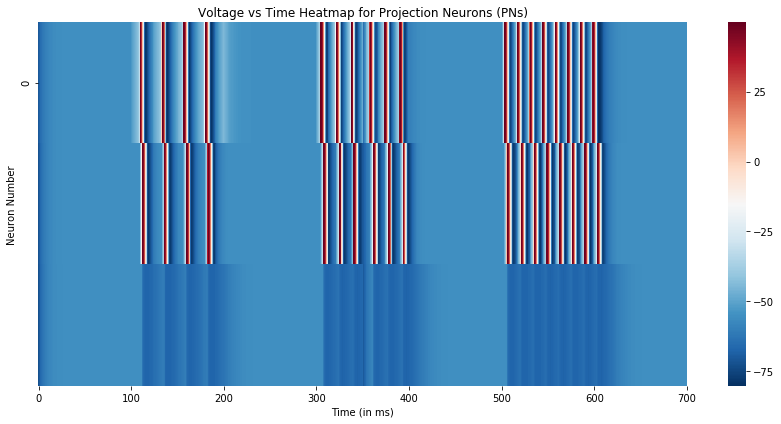

In [11]:
plt.figure(figsize=(12,6))
    
sns.heatmap(overall_state[::100,:3].T,xticklabels=100,yticklabels=5,cmap='RdBu_r')

plt.xlabel("Time (in ms)")
plt.ylabel("Neuron Number")
plt.title("Voltage vs Time Heatmap for Projection Neurons (PNs)")

plt.tight_layout()
plt.show()

### Other Limitations

With the runner-caller implementation, we have solved the issue of memory limitation. But there are some issues we havent solved yet.

1. **Delay Dependent Activity:** If the implementation of an model requires a delay differential equation (DDEs) that accesses the value of the parameters at a earlier time, we cannot use this programming paradigm directly as it has only, at most, one timestep memory. This is also a limitation of using the scan function. Exploring alternatives to tf.scan() and other techniques of solving DDEs is an option.

2. **Optimal Distributed Computing:** To maximize the utility of distributed systems, the algorithm needs to be capable of splitting the computation into tasks that can be run parallely (simultaneously) in different computational units. Since we are working with numerical integration, the results of the last step need to be known to perform the next computation. This, in a way limits out ability to use distributed computing. TensorFlow automatically tries to utilize all available resources efficiently but it may not be the optimal usage, for example, by default, it cannot utilize more than one GPU or access other nodes in a cluster. One way to enforce distribution is to manually distribute parts of the computational graph to specialized computing units. For example, the actual session can be forced to be executed on the server with maximum memory but the sub-computations such as the RK4 integration steps can be distributed to servers with more GPUs. See Supplementary on Distributed Computing for more Information.